# Homework 9

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Problem 1: Corrupted MNist Dataset

The following dataset was generated by adding some images to the digits 1 and 5 images in the MNIST dataset.

In [34]:
data = pd.read_csv('mnist_corrupted')

In [35]:
X = data.to_numpy()
X.shape

(14290, 784)

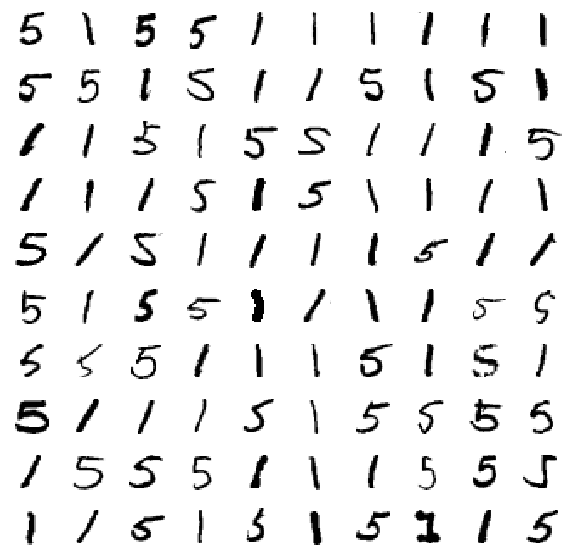

In [36]:
'100 digits randomly selected'
plt.figure(figsize=(10,10))
for i in range(100):
    idx = np.random.randint(14290)
    digit = X[idx]
    digit_image = digit.reshape(28,28)
    plt.subplot(10,10,i+1)
    plt.imshow(digit_image,cmap = 'binary')
    plt.axis('off')

Apply an anomaly detection method to this dataset. 
Display the images with the 100 largest anomaly scores. 
Do you see the added images?

**Anomaly Score based on PCA**

In [5]:
def anomalyScores_PCA(X,k):
    'scale the dataset'
    means = np.mean(X,axis=0)
    stds = np.std(X,axis=0)
    stds[stds==0] = 1 # to handle the columns equal to the zero vector
    X_scaled = (X-means)/stds
    'compute the singular value decomposition'
    _,_,v = np.linalg.svd(X_scaled,full_matrices=False) # singular value decomposition
    'reconstruct X_scaled based on the first k principal components'
    X_reconstructed = (X_scaled@v[:k].T)@v[:k]
    'compute anomaly scores'
    scores = np.linalg.norm(X_scaled-X_reconstructed,axis=1)
    scores = (scores-np.min(scores))/(np.max(scores)-np.min(scores))
    return scores

In [17]:
scores = anomalyScores_PCA(X,10)

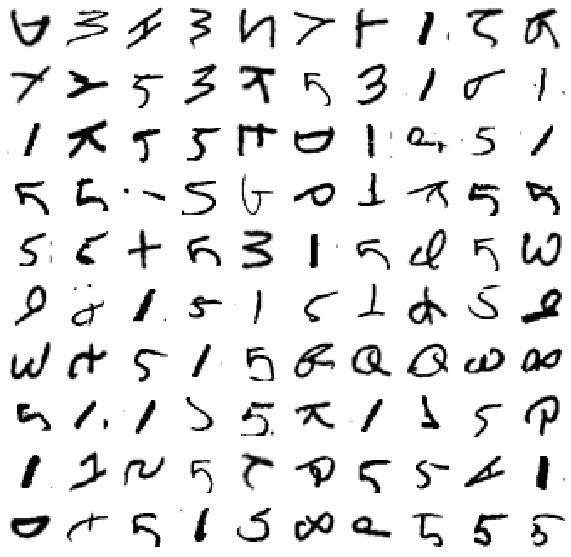

In [18]:
idx = np.argsort(scores)[::-1] # sort scores
plt.figure(figsize=(10,10))
for i in range(100): # display the images with the 100 largest anomaly scores
    digit = X[idx[i]]
    digit_image = digit.reshape(28,28)
    plt.subplot(10,10,i+1)
    plt.imshow(digit_image,cmap = 'binary')
    plt.axis('off')

**Anomaly Score based on density**

In [5]:
def anomalyScores_density(X,k):
    from scipy.spatial import distance
    m,_ = X.shape
    dist = distance.squareform(distance.pdist(X))
    neighbors = np.argsort(dist, axis=1)[:,1:k+1]
    densities = 1/np.array([np.mean(dist[i,neighbors[i]]) for i in range(m)])
    scores = np.array([np.mean(densities[neighbors[i]])/(densities[i]) for i in range(m)])
    # scale the scores so that they are within a zero to one range
    scores = (scores-np.min(scores))/(np.max(scores)-np.min(scores))
    return scores

In [27]:
scores = anomalyScores_density(X,10)

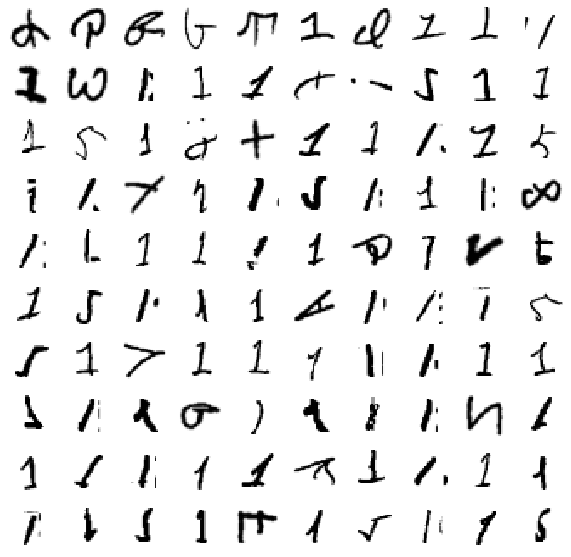

In [28]:
idx = np.argsort(scores)[::-1]
plt.figure(figsize=(10,10))
for i in range(100):
    digit = X[idx[i]]
    digit_image = digit.reshape(28,28)
    plt.subplot(10,10,i+1)
    plt.imshow(digit_image,cmap = 'binary')
    plt.axis('off')

## Problem 2: Node Failure in a Network of Servers

In this exercise, you will implement an anomaly detection algorithm and apply it to detect failing servers on a network

In [2]:
'load the data'
url1 = 'https://raw.githubusercontent.com/um-perez-alvaro/Anomaly-Detection/master/node_failure.csv'
url2 = 'https://raw.githubusercontent.com/um-perez-alvaro/Anomaly-Detection/master/node_failure_labels.csv'
data = pd.read_csv(url1, header = None)
labels = pd.read_csv(url2, header = None)

In [38]:
data.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,18.2710,-12.3590,5.0010,1.6115,1.0886,29.314,-8.3135,36.4380,-9.47670,-25.92800,7.1086
1,-3.1931,-19.7060,6.5286,-21.5710,3.0506,23.478,-1.1334,12.6880,-10.96800,-1.19870,1.9084
2,-5.2567,-12.9190,25.4350,-7.2316,3.6478,12.367,-6.5121,8.7509,-0.76875,-3.26110,13.7290
3,12.9530,-10.3500,19.8580,-24.4250,3.2661,30.445,-11.1260,12.8160,9.35140,-6.11360,17.6270
4,3.7638,-5.7282,11.4000,-17.5550,-6.2466,16.156,-9.7248,16.9970,-5.16870,0.18799,11.4010


Each observation is a "response" from a server.
Each observations has 11 features capturing the properties of computer servers like throughput in mb/sec and latency in milliseconds.
For this datset, we have labels for the observations, meaning we know which server responses actually heralded a server failure and are considered "anomalous".

In [3]:
X = data.to_numpy()
y = labels.to_numpy().flatten()
X.shape

(100, 11)

**Part 1.** Implement an anomaly detection algorithm and apply it to detect anomalous behavior of server computers on the dataset.
 Use the precision-recall curve or the F1-score to select the best anomaly-score threshold (see the Credit Card Fraud Jupyter Notebook).

**Using F1-scores**

Text(0, 0.5, 'F1-score')

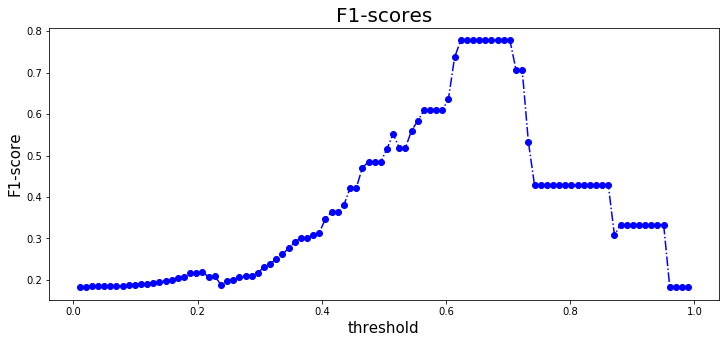

In [7]:
'compute anomaly scores'
k = 4 # number of principal components
scores = anomalyScores_PCA(X,k) 
'compute F1-score for different thresholds'
threshold_list  = np.linspace(0.01,.99,100) 
F1_score = np.zeros(100) 
i = 0
for threshold in threshold_list: # try different threshold values
    # anomaly predictions
    prediction = np.zeros(len(scores))
    prediction[scores>=threshold] = 1 
    # precision and recall
    TP = np.sum(prediction[y==1]==1) # numbef of true positives
    TN = np.sum(prediction[y==0]==0) # number of true negatives
    FP = np.sum(prediction[y==0]==1) # number of false positives
    FN = np.sum(prediction[y==1]==0) # number of false negatives
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    if precision*recall!=0:
        F1_score[i] = 2*(precision*recall)/(precision+recall)
    else:
        F1_score[i]=0 # the harmonic mean is undefined if both precision and recall are zero
    i = i+1
'Plot F1-scores'
plt.figure(figsize=(12,5))
plt.plot(threshold_list,F1_score,'bo-.')
plt.title('F1-scores',fontsize=20)
plt.xlabel('threshold',fontsize=15)
plt.ylabel('F1-score',fontsize=15)

In [8]:
'best threshold value'
i = np.argmax(F1_score)
best_threshold = threshold_list[i]
best_threshold

0.6237373737373737

**Precision-recall curve**

Text(0, 0.5, 'Precision')

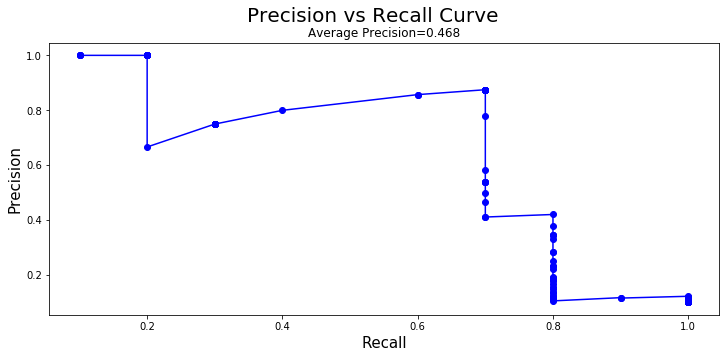

In [9]:
'Precision-Recall Curve'
precision = np.zeros(100)
recall = np.zeros(100)
i = 0
for threshold in threshold_list: # try different threshold values
    # anomaly predictions
    prediction = np.zeros(len(scores))
    prediction[scores>=threshold] = 1 
    # precision and recall
    TP = np.sum(prediction[y==1]==1) # numbef of true positives
    TN = np.sum(prediction[y==0]==0) # number of true negatives
    FP = np.sum(prediction[y==0]==1) # number of false positives
    FN = np.sum(prediction[y==1]==0) # number of false negatives
    recall[i] = TP/(TP+FN)
    precision[i] = TP/(TP+FP)
    i = i+1
'Plot precision vs recall curve'
plt.figure(figsize=(12,5))
plt.plot(recall,precision,'bo-')
plt.suptitle('Precision vs Recall Curve',fontsize=20)
plt.title('Average Precision='+str(np.round(np.mean(precision),3)))
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)

**Part 2.** Find anomalies in the following (unlabeled) dataset

In [10]:
url3 = 'https://raw.githubusercontent.com/um-perez-alvaro/Anomaly-Detection/master/node_failure_test.csv'
data_test = pd.read_csv(url3, header = None)

In [11]:
data_test.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,6.6531,13.6900,17.5530,-11.9330,-5.7564,15.4360,-12.13700,8.22410,-4.88400,5.34930,17.351000
1,-5.6305,-18.9380,18.6450,-6.1558,-25.9890,15.4100,-16.59600,9.45470,-2.87720,-6.00940,19.211000
2,9.7215,-9.9825,15.5710,-32.2240,-5.5958,24.3210,0.83277,10.79500,0.72757,10.39300,7.086000
3,-4.6358,-10.7160,20.3570,-9.0021,-4.9206,-4.2620,-1.30580,0.94998,-8.63410,0.19845,0.006771
4,-12.8410,-20.3880,9.4919,-7.0385,-9.9211,-3.7161,-9.38470,-2.32550,-13.51900,11.00700,14.003000


In [12]:
X_test = data_test.to_numpy()
y_test = np.zeros(len(X_test))

In [14]:
scores = anomalyScores_PCA(X_test,k)
y_test[scores>=best_threshold]=1
print(str(np.sum(y_test))+' anomalies detected')

15.0 anomalies detected


Let us try to visualize the anomalies using PCA

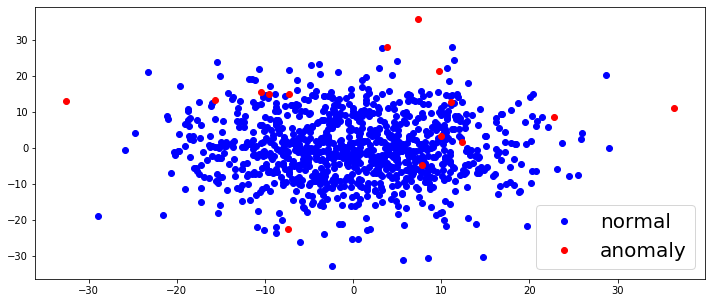

In [15]:
'center dataset'
X_centered = X_test-np.mean(X_test,axis=0)
'singular value decomposition'
u,s,v = np.linalg.svd(X_centered) 
'reduce dimension down to 2'
k = 2 # two-dimensional visualization 
X_reduced = X_centered@v[:k].T
'plot reduced dataset'
colors = ['blue','red']
classes = ['normal', 'anomaly']
plt.figure(figsize=(12,5))
for i in range(2):
    plt.plot(X_reduced[y_test==i,0],X_reduced[y_test==i,1],'o',c = colors[i], label=classes[i])
    plt.legend(fontsize=20)

## Problem 3: Anomaly Detection Datasets

Choose three datasets from the Anomaly Detection Datasets Jupyter Notebook.
For each dataset, implement an anomaly detection algorithm.

**Satellite Dataset Dataset**

In [65]:
url1 = 'https://raw.githubusercontent.com/um-perez-alvaro/Anomaly-Detection/master/satimage.csv'
url2 = 'https://raw.githubusercontent.com/um-perez-alvaro/Anomaly-Detection/master/satimage_labels.csv'
data = pd.read_csv(url1,header=None)
labels = pd.read_csv(url2, header=None)

In [142]:
X = data.to_numpy()
X.shape

(5803, 36)

In [67]:
y = labels.to_numpy().flatten()
y.shape

(5803,)

Let us visualize the dataset using PCA

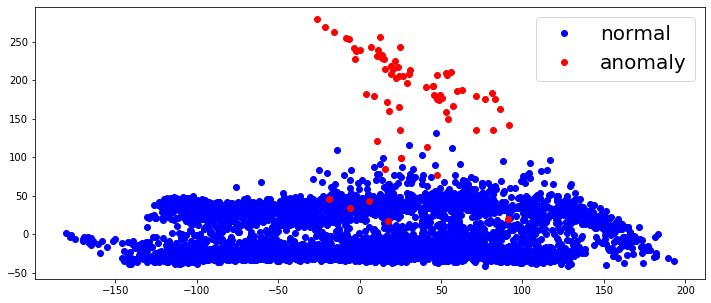

In [68]:
'center dataset'
X_centered = X-np.mean(X,axis=0)
'singular value decomposition'
u,s,v = np.linalg.svd(X_centered) 
'reduce dimension down to 2'
k = 2 # two-dimensional visualization 
X_reduced = X_centered@v[:k].T
'plot reduced dataset'
colors = ['blue','red']
classes = ['normal', 'anomaly']
plt.figure(figsize=(12,5))
for i in range(2):
    plt.plot(X_reduced[y==i,0],X_reduced[y==i,1],'o',c = colors[i], label=classes[i])
    plt.legend(fontsize=20)

Let us compute the anomaly scores based on PCA

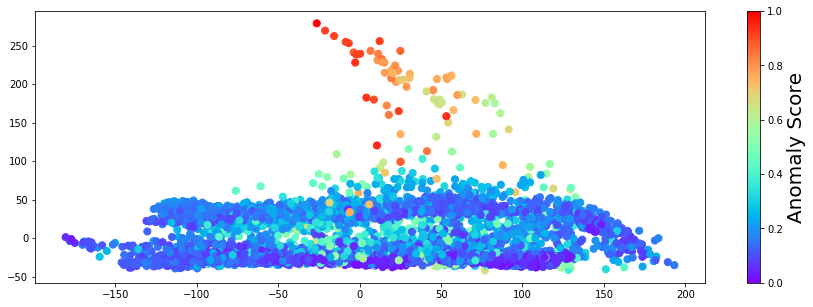

In [85]:
scores = anomalyScores_PCA(X,k=2)
plt.figure(figsize = (15,5))
plt.scatter(X_reduced[:,0],X_reduced[:,1],s=50, c=scores, cmap=plt.cm.rainbow)
cbar = plt.colorbar()
cbar.set_label('Anomaly Score',fontsize=20)

Text(0, 0.5, 'F1-score')

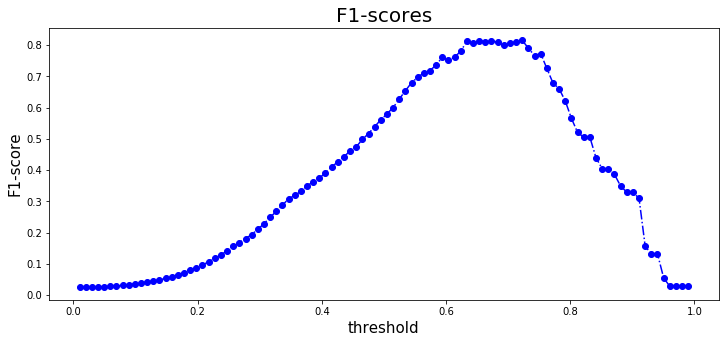

In [86]:
'compute F1-score for different thresholds'
threshold_list  = np.linspace(0.01,.99,100) 
F1_score = np.zeros(100) 
i = 0
for threshold in threshold_list: # try different threshold values
    # anomaly predictions
    prediction = np.zeros(len(scores))
    prediction[scores>=threshold] = 1 
    # precision and recall
    TP = np.sum(prediction[y==1]==1) # numbef of true positives
    TN = np.sum(prediction[y==0]==0) # number of true negatives
    FP = np.sum(prediction[y==0]==1) # number of false positives
    FN = np.sum(prediction[y==1]==0) # number of false negatives
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    if precision*recall!=0:
        F1_score[i] = 2*(precision*recall)/(precision+recall)
    else:
        F1_score[i]=0 # the harmonic mean is undefined if both precision and recall are zero
    i = i+1
'Plot F1-scores'
plt.figure(figsize=(12,5))
plt.plot(threshold_list,F1_score,'bo-.')
plt.title('F1-scores',fontsize=20)
plt.xlabel('threshold',fontsize=15)
plt.ylabel('F1-score',fontsize=15)

In [87]:
'best threshold value'
i = np.argmax(F1_score)
best_threshold = threshold_list[i]
best_threshold

0.7227272727272727

Text(0, 0.5, 'Precision')

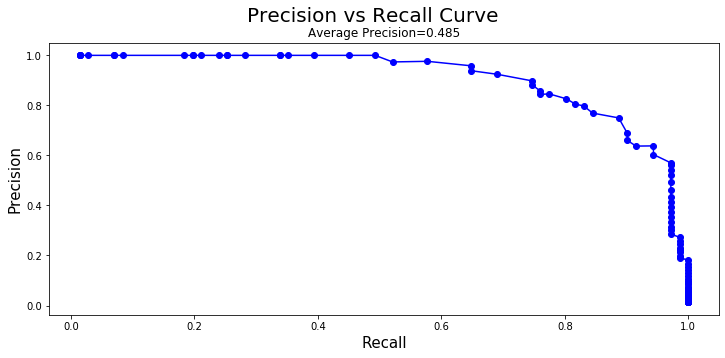

In [88]:
'Precision-Recall Curve'
precision = np.zeros(100)
recall = np.zeros(100)
i = 0
for threshold in threshold_list: # try different threshold values
    # anomaly predictions
    prediction = np.zeros(len(scores))
    prediction[scores>=threshold] = 1 
    # precision and recall
    TP = np.sum(prediction[y==1]==1) # numbef of true positives
    TN = np.sum(prediction[y==0]==0) # number of true negatives
    FP = np.sum(prediction[y==0]==1) # number of false positives
    FN = np.sum(prediction[y==1]==0) # number of false negatives
    recall[i] = TP/(TP+FN)
    precision[i] = TP/(TP+FP)
    i = i+1
'Plot precision vs recall curve'
plt.figure(figsize=(12,5))
plt.plot(recall,precision,'bo-')
plt.suptitle('Precision vs Recall Curve',fontsize=20)
plt.title('Average Precision='+str(np.round(np.mean(precision),3)))
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)

## Problem 4: Anomaly Detection as a Classification Problem

For each of the datasets in Problem 3, use the labels to train a classification algorithm (regression, SVD, knn, classification tree, etc). 
Does it work better than the anomaly detection algorithm?

I'll try logistic regression

**Logistic Regression**

In [143]:
X_scaled = X/np.max(X,axis=0)

In [167]:
'sigmoid function'
def sigmoid(t):
    return 1/(1+np.exp(-t))
'cost function'
def cost(y,X,theta):
    m = len(y)
    return -1/m*(y.T@np.log(sigmoid(X@theta))+(1-y).T@np.log(1-sigmoid(X@theta)))
'Logistic regression with Gradient Descent'
def log_regression_GD(X,y,s,n_iterations):
    m,n = X.shape
    theta = np.random.randn(n,1)
    E = np.zeros(n_iterations)
    for i in range(n_iterations):
        gradient = (1/m)*X.T@(sigmoid(X@theta)-y) # compute gradient
        theta = theta - s*gradient # Gradient Descent Step
        E[i] = cost(y,X,theta) # compute the cost function
    return E,theta

Text(0, 0.5, 'Cost')

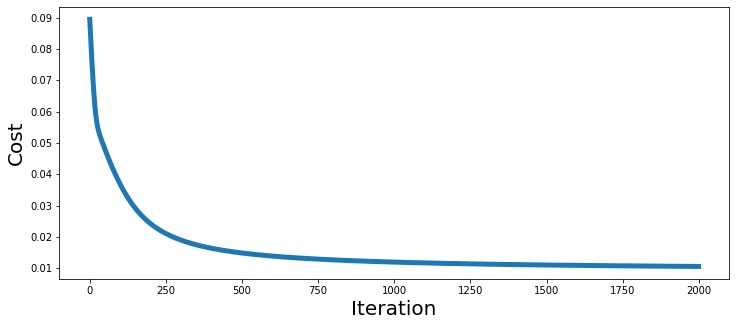

In [170]:
E, theta = log_regression_GD(X_scaled,y[:,None],s=1, n_iterations = 2000)
plt.figure(figsize=(12,5))
plt.plot(E,linewidth=5)
plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Cost',fontsize=20)

In [176]:
scores = sigmoid(X_scaled@theta).flatten()

Text(0, 0.5, 'F1-score')

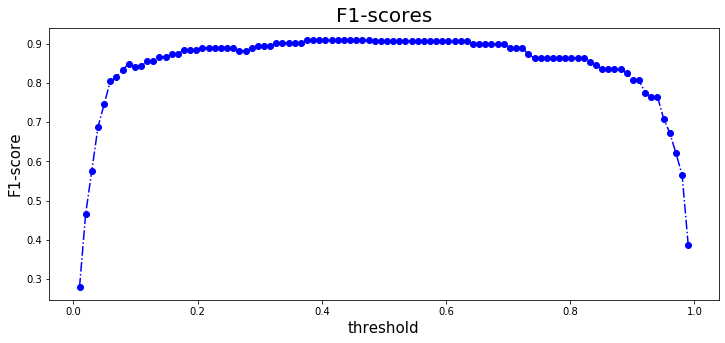

In [177]:
'compute F1-score for different thresholds'
threshold_list  = np.linspace(0.01,.99,100) 
F1_score = np.zeros(100) 
i = 0
for threshold in threshold_list: # try different threshold values
    # anomaly predictions
    prediction = np.zeros(len(scores))
    prediction[scores>=threshold] = 1 
    # precision and recall
    TP = np.sum(prediction[y==1]==1) # numbef of true positives
    TN = np.sum(prediction[y==0]==0) # number of true negatives
    FP = np.sum(prediction[y==0]==1) # number of false positives
    FN = np.sum(prediction[y==1]==0) # number of false negatives
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    if precision*recall!=0:
        F1_score[i] = 2*(precision*recall)/(precision+recall)
    else:
        F1_score[i]=0 # the harmonic mean is undefined if both precision and recall are zero
    i = i+1
'Plot F1-scores'
plt.figure(figsize=(12,5))
plt.plot(threshold_list,F1_score,'bo-.')
plt.title('F1-scores',fontsize=20)
plt.xlabel('threshold',fontsize=15)
plt.ylabel('F1-score',fontsize=15)

Text(0, 0.5, 'Precision')

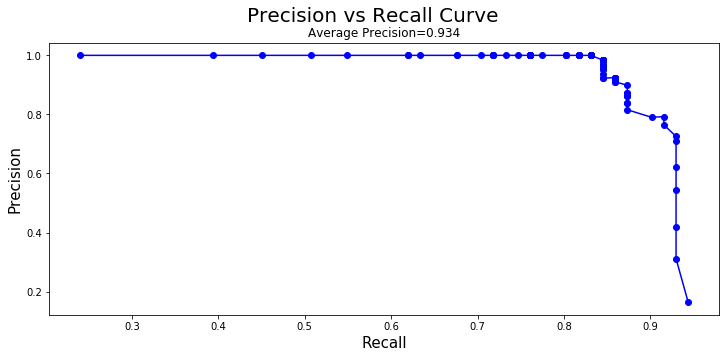

In [182]:
'Precision-Recall Curve'
precision = np.zeros(100)
recall = np.zeros(100)
i = 0
for threshold in threshold_list: # try different threshold values
    # anomaly predictions
    prediction = np.zeros(len(scores))
    prediction[scores>=threshold] = 1 
    # precision and recall
    TP = np.sum(prediction[y==1]==1) # numbef of true positives
    TN = np.sum(prediction[y==0]==0) # number of true negatives
    FP = np.sum(prediction[y==0]==1) # number of false positives
    FN = np.sum(prediction[y==1]==0) # number of false negatives
    recall[i] = TP/(TP+FN)
    precision[i] = TP/(TP+FP)
    i = i+1
'Plot precision vs recall curve'
plt.figure(figsize=(12,5))
plt.plot(recall,precision,'bo-')
plt.suptitle('Precision vs Recall Curve',fontsize=20)
plt.title('Average Precision='+str(np.round(np.mean(precision),3)))
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)

Logistic regression performs better than the PCA anomaly detection method!